In [1]:
# Install required packages
!pip install -U ultralytics  -q
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118   -q
!pip install seaborn pandas scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00


In [2]:
# Imports
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import cv2
from sklearn.metrics import confusion_matrix
import time
import json
from IPython.display import display, HTML
from IPython.display import Image, display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Downloads a zip file containing the dataset from a Google Drive

In [ ]:
!gdown --fuzzy 'https://drive.google.com/file/d/1BQGz3M1JeNrIJv3HOSruthztIVSn3A2H/view?usp=sharing' --output dataset.zip
!unzip -q dataset.zip -d dataset/   #unzips the dataset into a directory named dataset/

Downloading...
From (original): https://drive.google.com/uc?id=1BQGz3M1JeNrIJv3HOSruthztIVSn3A2H
From (redirected): https://drive.google.com/uc?id=1BQGz3M1JeNrIJv3HOSruthztIVSn3A2H&confirm=t&uuid=a3e5952e-5d81-4012-80dd-6ae6528174c3
To: /kaggle/working/dataset.zip
100%|██████████████████████████████████████| 2.11G/2.11G [00:24<00:00, 87.3MB/s]


In [ ]:
import os
# Define dataset path
ROOT_DIR = '/kaggle/working/dataset'
data_path = os.path.join(ROOT_DIR, 'data.yaml')
# Define output paths for saving results
output_dir = '/kaggle/working/model_comparison_HumanDetection'
metrics_dir = os.path.join(output_dir, 'individual_metrics')
history_dir = '/kaggle/working/model_history_HumanDetection'
# Create directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)
print("All directories created and paths set.")

All directories created and paths set.


### Defines helper functions for working with YOLO models

Helper: Train model This function takes a model name and the number of training epochs as input. It loads a pre-trained YOLO model, trains it on the specified data, records the training time, and returns the trained model, the training results, and the training time.

Helper: Evaluate model This function takes a trained model and its name as input. It evaluates the model on the validation set, saves the results, and returns the validation results.

Helper: Measure inference time This function takes a trained model and the path to a sample image as input, along with the number of runs for averaging. It measures the time it takes for the model to perform inference on the image over multiple runs and returns the average inference time.

In [ ]:
# Define dataset and project paths
ROOT_DIR = '/kaggle/working/dataset'
PROJECT_DIR = '/kaggle/working/model_comparison_HumanDetection'
# Helper: Train model
def train_model(model_name, epochs=20):
    model = YOLO(model_name + ".pt")  # Load pretrained model
    start_time = time.time()
    results = model.train(
        data=os.path.join(ROOT_DIR, "data.yaml"),
        epochs=epochs,
        imgsz=640,
        project=PROJECT_DIR,
        name=model_name,
        exist_ok=True
    )
    training_time = time.time() - start_time
    return model, results, training_time
# Helper: Evaluate model
def evaluate_model(model, model_name):
    return model.val(
        data=os.path.join(ROOT_DIR, "data.yaml"),
        save=True,
        project=PROJECT_DIR,
        name=model_name,
        exist_ok=True
    )
# Helper: Measure inference time
def measure_inference_time(model, img_path, runs=10):
    times = []
    for _ in range(runs):
        start = time.time()
        _ = model(img_path)
        end = time.time()
        times.append(end - start)
    return sum(times) / len(times)

# Helper: Get model size
def get_model_size(model_path):
    return os.path.getsize(model_path) / (1024 * 1024)  # in MB

##  Trains and evaluates YOLOv8m model

This code trains and evaluates the YOLOv8m model. It first sets the model_name to 'yolov8m'. Then, it calls the train_model function to train the model for 20 epochs, the evaluate_model function to evaluate the trained model on the validation set, and the measure_inference_time function to measure the inference time on a sample image from the test set. Finally, it calculates the model size and stores all the results in a dictionary called medium_results.

In [ ]:
model_name = 'yolov8m'
model, train_results, training_time = train_model(model_name, epochs=20)
val_results = evaluate_model(model, model_name)
test_path = os.path.join(ROOT_DIR, 'test/images')
sample_img = os.path.join(test_path, os.listdir(test_path)[0])
inference_time = measure_inference_time(model, sample_img)
model_path = train_results.save_dir
model_path = os.path.join(model_path, 'weights/best.pt')
model_size = get_model_size(model_path)
medium_results = {
    'train_results': train_results,
    'val_results': val_results,
    'training_time': training_time,
    'inference_time': inference_time,
    'model_size': model_size
}

100%|██████████| 49.7M/49.7M [00:00<00:00, 228MB/s]


Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pret

100%|██████████| 755k/755k [00:00<00:00, 16.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 70.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2223.2±913.5 MB/s, size: 185.8 KB)


train: Scanning /kaggle/working/dataset/train/labels... 15210 images, 1932 backgrounds, 0 corrupt: 100%|██████████| 15210/15210 [00:10<00:00, 1403.00it/s]

train: /kaggle/working/dataset/train/images/2007_000187_jpg.rf.6072bb3923494a7afb8648ba483324fd.jpg: 23 duplicate labels removed
train: /kaggle/working/dataset/train/images/2007_000999_jpg.rf.6c08f70e15d4b331a62dd733f71a31ef.jpg: 7 duplicate labels removed
train: /kaggle/working/dataset/train/images/2007_002260_jpg.rf.67b39e42171c963a3427b19a2abe68b4.jpg: 19 duplicate labels removed
train: /kaggle/working/dataset/train/images/2008_003417_jpg.rf.f31d813882efbf61f9f5526453e177e3.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset/train/images/2008_003522_jpg.rf.0c7864f40841e847ba3fb26e08efd3e3.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset/train/images/2008_006554_jpg.rf.f803f4b634de852ff949e04c8e89ced5.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset/train/images/2009_002733_jpg.rf.a2dac53f2d02cd54c047dc7af456e088.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/dataset/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 280, len(boxes) = 100029. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 499.8±114.3 MB/s, size: 162.2 KB)


val: Scanning /kaggle/working/dataset/valid/labels... 1431 images, 61 backgrounds, 0 corrupt: 100%|██████████| 1431/1431 [00:01<00:00, 1203.36it/s]

val: /kaggle/working/dataset/valid/images/GX010023_frame_00025_right_jpg.rf.3255febc597d78d5d6e4bde455ba7b2a.jpg: 23 duplicate labels removed
val: New cache created: /kaggle/working/dataset/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 61, len(boxes) = 10660. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /kaggle/working/model_comparison_HumanDetection/yolov8m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/model_comparison_HumanDetection/yolov8m
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.07G      1.432       1.26      1.358         61        640: 100%|██████████| 951/951 [08:50<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.50it/s]


                   all       1431      10660      0.641      0.484      0.496      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.19G      1.476      1.322      1.403        108        640: 100%|██████████| 951/951 [08:53<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.64it/s]


                   all       1431      10660      0.678      0.468      0.507      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.11G      1.401      1.239      1.362        104        640: 100%|██████████| 951/951 [08:49<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.65it/s]

                   all       1431      10660      0.696      0.508      0.564      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.82G      1.333       1.16       1.32         69        640: 100%|██████████| 951/951 [08:48<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.65it/s]

                   all       1431      10660      0.728       0.54      0.597      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.99G       1.28      1.094      1.287        141        640: 100%|██████████| 951/951 [08:48<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.65it/s]

                   all       1431      10660       0.74      0.551      0.612      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      7.83G      1.225      1.035      1.258         97        640: 100%|██████████| 951/951 [08:48<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.66it/s]

                   all       1431      10660      0.738       0.58      0.637      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      7.38G      1.191     0.9993      1.238         49        640: 100%|██████████| 951/951 [08:48<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.66it/s]

                   all       1431      10660      0.746      0.598      0.661      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.13G      1.154     0.9664      1.218        125        640: 100%|██████████| 951/951 [08:48<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.66it/s]

                   all       1431      10660      0.753      0.597      0.664       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      7.03G      1.122     0.9246      1.202        106        640: 100%|██████████| 951/951 [08:48<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.67it/s]

                   all       1431      10660      0.757      0.615      0.686      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.06G      1.093     0.8978      1.182        132        640: 100%|██████████| 951/951 [08:48<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.67it/s]

                   all       1431      10660      0.774      0.621        0.7      0.419


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.97G      1.077     0.8668      1.194         77        640: 100%|██████████| 951/951 [08:43<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.66it/s]

                   all       1431      10660      0.786       0.63      0.705       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      7.21G      1.056     0.8404      1.177         47        640: 100%|██████████| 951/951 [08:42<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.67it/s]

                   all       1431      10660      0.796      0.634      0.708      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.18G      1.031     0.8099      1.156         72        640: 100%|██████████| 951/951 [08:43<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.67it/s]

                   all       1431      10660      0.788      0.629      0.709      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.24G          1     0.7746      1.143         45        640: 100%|██████████| 951/951 [08:43<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]

                   all       1431      10660      0.781      0.658      0.726      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.19G     0.9747     0.7492      1.129          9        640: 100%|██████████| 951/951 [08:42<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]

                   all       1431      10660      0.802      0.664      0.737       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.85G     0.9463     0.7181      1.109         61        640: 100%|██████████| 951/951 [08:42<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]

                   all       1431      10660      0.802      0.669      0.742      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.51G      0.919     0.6905      1.096         65        640: 100%|██████████| 951/951 [08:42<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]

                   all       1431      10660      0.802       0.67      0.742      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.41G     0.8929     0.6653      1.081         57        640: 100%|██████████| 951/951 [08:42<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]

                   all       1431      10660      0.813      0.672       0.75      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.97G     0.8648     0.6353      1.065         39        640: 100%|██████████| 951/951 [08:42<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]

                   all       1431      10660       0.82      0.685       0.76      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.73G     0.8432      0.612      1.053        118        640: 100%|██████████| 951/951 [08:43<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]

                   all       1431      10660      0.805      0.695      0.764      0.501



20 epochs completed in 3.026 hours.
Optimizer stripped from /kaggle/working/model_comparison_HumanDetection/yolov8m/weights/last.pt, 52.0MB
Optimizer stripped from /kaggle/working/model_comparison_HumanDetection/yolov8m/weights/best.pt, 52.0MB

Validating /kaggle/working/model_comparison_HumanDetection/yolov8m/weights/best.pt...
Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


                   all       1431      10660      0.809      0.694      0.764      0.501


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 7.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/model_comparison_HumanDetection/yolov8m
Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1201.7±292.5 MB/s, size: 35.0 KB)


val: Scanning /kaggle/working/dataset/valid/labels.cache... 1431 images, 61 backgrounds, 0 corrupt: 100%|██████████| 1431/1431 [00:00<?, ?it/s]

val: /kaggle/working/dataset/valid/images/GX010023_frame_00025_right_jpg.rf.3255febc597d78d5d6e4bde455ba7b2a.jpg: 23 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 61, len(boxes) = 10660. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 90/90 [00:32<00:00,  2.78it/s]


                   all       1431      10660      0.811      0.694      0.764      0.502


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 17.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/model_comparison_HumanDetection/yolov8m

image 1/1 /kaggle/working/dataset/test/images/2008_000583_jpg.rf.c20fda77b68b737d6265ebb73f4264f2.jpg: 448x640 2 persons, 43.2ms
Speed: 2.2ms preprocess, 43.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/working/dataset/test/images/2008_000583_jpg.rf.c20fda77b68b737d6265ebb73f4264f2.jpg: 448x640 2 persons, 27.2ms
Speed: 2.0ms preprocess, 27.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/working/dataset/test/images/2008_000583_jpg.rf.c20fda77b68b737d6265ebb73f4264f2.jpg: 448x640 2 persons, 27.3ms
Speed: 1.6ms preprocess, 27.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/working/dataset/test/images/2008_000583_jpg.rf.c20fda77b68b737d6265ebb73f4264f2.jpg: 448x640 2 persons, 21.4ms
Speed: 1.7ms preprocess, 21.4ms i

### Evaluation metrics for the YOLOv8 Medium model

In [ ]:
precision = val_results.box.p[0]
recall = val_results.box.r[0]
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f"\nYOLOv8 Medium Results:")
print(f"mAP50: {val_results.box.map50:.3f}")
print(f"mAP50-95: {val_results.box.map:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1_score:.3f}")
print(f"Inference Time: {inference_time:.2f} ms")
print(f"Model Size: {model_size:.1f} MB")
print(f"Training Time: {training_time/60:.1f} minutes")


YOLOv8 Medium Results:
mAP50: 0.764
mAP50-95: 0.502
Precision: 0.811
Recall: 0.694
F1-Score: 0.748
Inference Time: 0.04 ms
Model Size: 49.6 MB
Training Time: 182.4 minutes


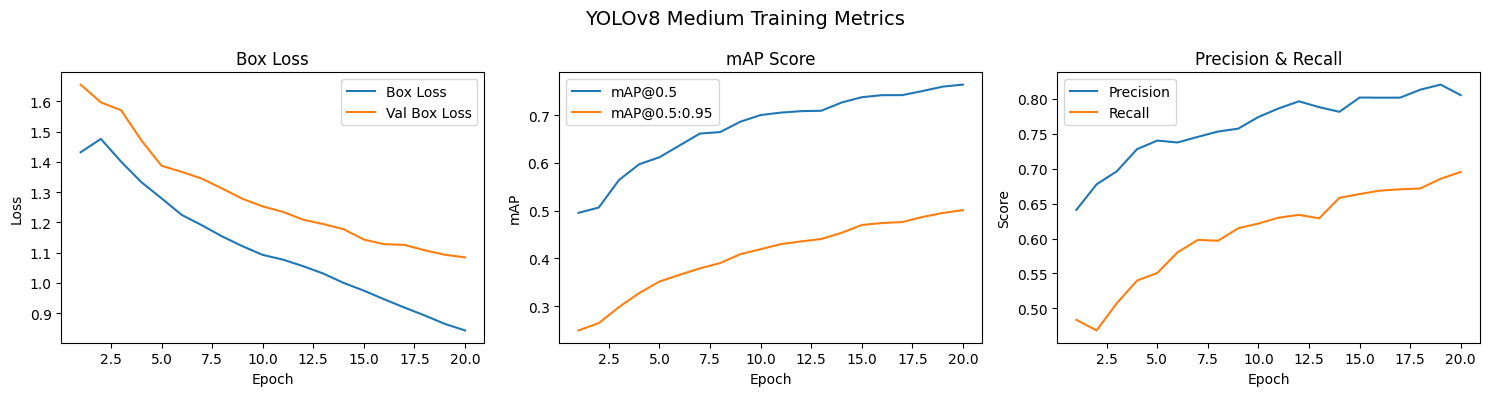

In [ ]:
metrics_path = os.path.join(medium_results['train_results'].save_dir, 'results.csv')
if os.path.exists(metrics_path):
    df = pd.read_csv(metrics_path)
    epochs = df.index + 1
    plt.figure(figsize=(15, 4))
    plt.suptitle("YOLOv8 Medium Training Metrics", fontsize=14)
    # Box Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, df['train/box_loss'], label='Box Loss')
    plt.plot(epochs, df['val/box_loss'], label='Val Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Box Loss')
    plt.legend()
    # mAP
    plt.subplot(1, 3, 2)
    plt.plot(epochs, df['metrics/mAP50(B)'], label='mAP@0.5')
    plt.plot(epochs, df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title('mAP Score')
    plt.legend()
    # Precision / Recall
    plt.subplot(1, 3, 3)
    plt.plot(epochs, df['metrics/precision(B)'], label='Precision')
    plt.plot(epochs, df['metrics/recall(B)'], label='Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Precision & Recall')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Warning: Metrics file not found at {metrics_path}")

## Trains and evaluates YOLOv8n model

This code trains and evaluates the YOLOv8n model. It first sets the model_name to 'yolov8n'. Then, it calls the train_model function to train the model for 20 epochs, the evaluate_model function to evaluate the trained model on the validation set, and the measure_inference_time function to measure the inference time on a sample image from the test set. Finally, it calculates the model size and stores all the results in a dictionary called medium_results

In [ ]:
model_name = 'yolov8n'
model, train_results, training_time = train_model(model_name, epochs=20)
val_results = evaluate_model(model, model_name)
test_path = os.path.join(ROOT_DIR, 'test/images')
sample_img = os.path.join(test_path, os.listdir(test_path)[0])
inference_time = measure_inference_time(model, sample_img)
model_path = train_results.save_dir
model_path = os.path.join(model_path, 'weights/best.pt')
model_size = get_model_size(model_path)
nano_results = {
    'train_results': train_results,
    'val_results': val_results,
    'training_time': training_time,
    'inference_time': inference_time,
    'model_size': model_size
}

Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pret

train: Scanning /kaggle/working/dataset/train/labels.cache... 15210 images, 1932 backgrounds, 0 corrupt: 100%|██████████| 15210/15210 [00:00<?, ?it/s]

train: /kaggle/working/dataset/train/images/2007_000187_jpg.rf.6072bb3923494a7afb8648ba483324fd.jpg: 23 duplicate labels removed
train: /kaggle/working/dataset/train/images/2007_000999_jpg.rf.6c08f70e15d4b331a62dd733f71a31ef.jpg: 7 duplicate labels removed
train: /kaggle/working/dataset/train/images/2007_002260_jpg.rf.67b39e42171c963a3427b19a2abe68b4.jpg: 19 duplicate labels removed
train: /kaggle/working/dataset/train/images/2008_003417_jpg.rf.f31d813882efbf61f9f5526453e177e3.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset/train/images/2008_003522_jpg.rf.0c7864f40841e847ba3fb26e08efd3e3.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset/train/images/2008_006554_jpg.rf.f803f4b634de852ff949e04c8e89ced5.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset/train/images/2009_002733_jpg.rf.a2dac53f2d02cd54c047dc7af456e088.jpg: 1 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 280, len(boxes) = 100029. T

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 353.0±147.4 MB/s, size: 162.2 KB)


val: Scanning /kaggle/working/dataset/valid/labels.cache... 1431 images, 61 backgrounds, 0 corrupt: 100%|██████████| 1431/1431 [00:00<?, ?it/s]

val: /kaggle/working/dataset/valid/images/GX010023_frame_00025_right_jpg.rf.3255febc597d78d5d6e4bde455ba7b2a.jpg: 23 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 61, len(boxes) = 10660. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /kaggle/working/model_comparison_HumanDetection/yolov8n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/model_comparison_HumanDetection/yolov8n
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.08G        1.5      1.521      1.308         61        640: 100%|██████████| 951/951 [02:57<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.23it/s]


                   all       1431      10660       0.67       0.43      0.461      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.08G      1.529      1.403      1.339        108        640: 100%|██████████| 951/951 [02:52<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.33it/s]


                   all       1431      10660      0.601       0.44      0.456      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.08G      1.497       1.36       1.33        104        640: 100%|██████████| 951/951 [02:51<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.33it/s]


                   all       1431      10660      0.635      0.456      0.496      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.08G      1.459      1.305      1.305         69        640: 100%|██████████| 951/951 [02:51<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.43it/s]


                   all       1431      10660      0.706      0.489      0.554      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.08G      1.418      1.251      1.281        141        640: 100%|██████████| 951/951 [02:51<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.43it/s]


                   all       1431      10660       0.71      0.514      0.579      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.08G      1.372        1.2      1.257         97        640: 100%|██████████| 951/951 [02:51<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.47it/s]


                   all       1431      10660      0.704      0.511      0.577      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.08G      1.345       1.17      1.244         49        640: 100%|██████████| 951/951 [02:52<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.44it/s]


                   all       1431      10660      0.733      0.538      0.608       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.08G      1.323      1.144      1.232        125        640: 100%|██████████| 951/951 [02:50<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.32it/s]


                   all       1431      10660      0.736      0.553      0.614      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.08G      1.292      1.108      1.218        106        640: 100%|██████████| 951/951 [02:50<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.43it/s]


                   all       1431      10660      0.724      0.547      0.619      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.08G      1.273       1.09      1.205        132        640: 100%|██████████| 951/951 [02:51<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.29it/s]


                   all       1431      10660      0.728       0.55      0.627      0.353
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.08G      1.256      1.048      1.209         77        640: 100%|██████████| 951/951 [02:45<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.39it/s]


                   all       1431      10660       0.74      0.556      0.624      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.08G       1.24      1.027      1.199         47        640: 100%|██████████| 951/951 [02:44<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.52it/s]


                   all       1431      10660      0.739      0.562      0.638      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.09G      1.222     0.9976      1.186         72        640: 100%|██████████| 951/951 [02:43<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.41it/s]


                   all       1431      10660       0.75       0.57      0.646       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       5.1G      1.193     0.9745      1.174         45        640: 100%|██████████| 951/951 [02:44<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.46it/s]


                   all       1431      10660      0.756      0.576      0.659      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.11G      1.175     0.9504      1.164          9        640: 100%|██████████| 951/951 [02:45<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.47it/s]


                   all       1431      10660      0.771       0.58      0.666      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.11G      1.155     0.9295      1.151         61        640: 100%|██████████| 951/951 [02:44<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.48it/s]


                   all       1431      10660      0.766      0.588      0.666      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.11G      1.135     0.9092      1.141         65        640: 100%|██████████| 951/951 [02:43<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.49it/s]

                   all       1431      10660       0.76      0.593      0.672      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.11G      1.116     0.8852      1.131         57        640: 100%|██████████| 951/951 [02:44<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.47it/s]


                   all       1431      10660      0.774      0.598      0.677      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.11G      1.094      0.864       1.12         39        640: 100%|██████████| 951/951 [02:44<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.45it/s]


                   all       1431      10660      0.759      0.604      0.678      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.11G       1.08     0.8465       1.11        118        640: 100%|██████████| 951/951 [02:44<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:08<00:00,  5.47it/s]

                   all       1431      10660       0.76      0.616      0.688      0.406



20 epochs completed in 0.984 hours.
Optimizer stripped from /kaggle/working/model_comparison_HumanDetection/yolov8n/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/model_comparison_HumanDetection/yolov8n/weights/best.pt, 6.2MB

Validating /kaggle/working/model_comparison_HumanDetection/yolov8n/weights/best.pt...
Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.25it/s]


                   all       1431      10660       0.76      0.617      0.688      0.406


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/model_comparison_HumanDetection/yolov8n
Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 747.4±294.8 MB/s, size: 35.0 KB)


val: Scanning /kaggle/working/dataset/valid/labels.cache... 1431 images, 61 backgrounds, 0 corrupt: 100%|██████████| 1431/1431 [00:00<?, ?it/s]

val: /kaggle/working/dataset/valid/images/GX010023_frame_00025_right_jpg.rf.3255febc597d78d5d6e4bde455ba7b2a.jpg: 23 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 61, len(boxes) = 10660. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 90/90 [00:11<00:00,  7.52it/s]


                   all       1431      10660       0.76      0.617      0.688      0.407


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/model_comparison_HumanDetection/yolov8n

image 1/1 /kaggle/working/dataset/test/images/2008_000583_jpg.rf.c20fda77b68b737d6265ebb73f4264f2.jpg: 448x640 2 persons, 31.0ms
Speed: 1.9ms preprocess, 31.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/working/dataset/test/images/2008_000583_jpg.rf.c20fda77b68b737d6265ebb73f4264f2.jpg: 448x640 2 persons, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/working/dataset/test/images/2008_000583_jpg.rf.c20fda77b68b737d6265ebb73f4264f2.jpg: 448x640 2 persons, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/working/dataset/test/images/2008_000583_jpg.rf.c20fda77b68b737d6265ebb73f4264f2.jpg: 448x640 2 persons, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inferenc

Evaluation metrics for the YOLOv8 Nano model

In [ ]:
precision = val_results.box.p[0]
recall = val_results.box.r[0]
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print(f"\nYOLOv8 Nano Results:")
print(f"mAP50: {val_results.box.map50:.3f}")
print(f"mAP50-95: {val_results.box.map:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1_score:.3f}")
print(f"Inference Time: {inference_time:.2f} ms")
print(f"Model Size: {model_size:.1f} MB")
print(f"Training Time: {training_time/60:.1f} minutes")


YOLOv8 Nano Results:
mAP50: 0.688
mAP50-95: 0.407
Precision: 0.760
Recall: 0.617
F1-Score: 0.681
Inference Time: 0.02 ms
Model Size: 5.9 MB
Training Time: 59.4 minutes


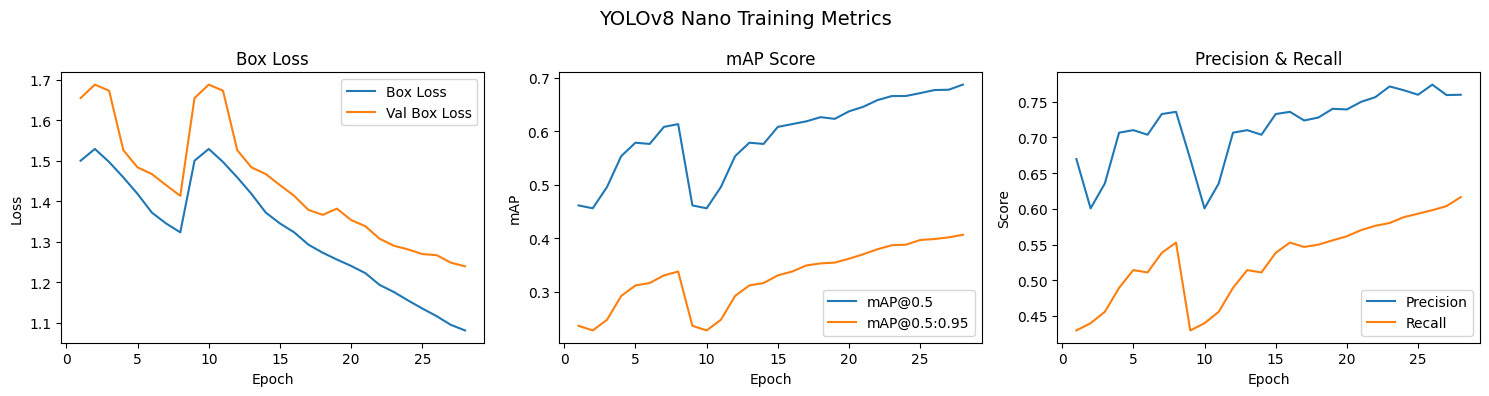

In [ ]:
metrics_path = os.path.join(nano_results['train_results'].save_dir, 'results.csv')
# Check if the file exists before proceeding
if os.path.exists(metrics_path):
    df = pd.read_csv(metrics_path)
    epochs = df.index + 1
    plt.figure(figsize=(15, 4))
    plt.suptitle("YOLOv8 Nano Training Metrics", fontsize=14)
    # Box Loss
    plt.subplot(1, 3, 1)
    # Updated column names
    plt.plot(epochs, df['train/box_loss'], label='Box Loss')
    plt.plot(epochs, df['val/box_loss'], label='Val Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Box Loss')
    plt.legend()
    # mAP
    plt.subplot(1, 3, 2)
    # Updated column names
    plt.plot(epochs, df['metrics/mAP50(B)'], label='mAP@0.5')
    plt.plot(epochs, df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title('mAP Score')
    plt.legend()
    # Precision / Recall
    plt.subplot(1, 3, 3)
    # Updated column names
    plt.plot(epochs, df['metrics/precision(B)'], label='Precision')
    plt.plot(epochs, df['metrics/recall(B)'], label='Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Precision & Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print(f"Warning: Metrics file not found at {metrics_path}")

## Trains and Evaluates YOLOv8s model

This code trains and evaluates the YOLOv8s model. It first sets the model_name to 'yolov8s'. Then, it calls the train_model function to train the model for 20 epochs, the evaluate_model function to evaluate the trained model on the validation set, and the measure_inference_time function to measure the inference time on a sample image from the test set. Finally, it calculates the model size and stores all the results in a dictionary called medium_results

In [ ]:
# Define model name
model_name = 'yolov8s'
model, train_results, training_time = train_model(model_name, epochs=20)
val_results = evaluate_model(model, model_name)
test_path = os.path.join(ROOT_DIR, 'test/images')
sample_img = os.path.join(test_path, os.listdir(test_path)[0])
inference_time = measure_inference_time(model, sample_img)
model_path = train_results.save_dir
model_path = os.path.join(model_path, 'weights/best.pt')
model_size = get_model_size(model_path)
small_results = {
    'train_results': train_results,
    'val_results': val_results,
    'training_time': training_time,
    'inference_time': inference_time,
    'model_size': model_size
}

100%|██████████| 21.5M/21.5M [00:00<00:00, 154MB/s]


Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pret

train: Scanning /kaggle/working/dataset/train/labels.cache... 15210 images, 1932 backgrounds, 0 corrupt: 100%|██████████| 15210/15210 [00:00<?, ?it/s]

train: /kaggle/working/dataset/train/images/2007_000187_jpg.rf.6072bb3923494a7afb8648ba483324fd.jpg: 23 duplicate labels removed
train: /kaggle/working/dataset/train/images/2007_000999_jpg.rf.6c08f70e15d4b331a62dd733f71a31ef.jpg: 7 duplicate labels removed
train: /kaggle/working/dataset/train/images/2007_002260_jpg.rf.67b39e42171c963a3427b19a2abe68b4.jpg: 19 duplicate labels removed
train: /kaggle/working/dataset/train/images/2008_003417_jpg.rf.f31d813882efbf61f9f5526453e177e3.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset/train/images/2008_003522_jpg.rf.0c7864f40841e847ba3fb26e08efd3e3.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset/train/images/2008_006554_jpg.rf.f803f4b634de852ff949e04c8e89ced5.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset/train/images/2009_002733_jpg.rf.a2dac53f2d02cd54c047dc7af456e088.jpg: 1 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 280, len(boxes) = 100029. T

val: Fast image access ✅ (ping: 0.0±0.1 ms, read: 443.2±81.6 MB/s, size: 162.2 KB)


val: Scanning /kaggle/working/dataset/valid/labels.cache... 1431 images, 61 backgrounds, 0 corrupt: 100%|██████████| 1431/1431 [00:00<?, ?it/s]

val: /kaggle/working/dataset/valid/images/GX010023_frame_00025_right_jpg.rf.3255febc597d78d5d6e4bde455ba7b2a.jpg: 23 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 61, len(boxes) = 10660. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /kaggle/working/model_comparison_HumanDetection/yolov8s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/model_comparison_HumanDetection/yolov8s
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.07G      1.434      1.276      1.295         61        640: 100%|██████████| 951/951 [04:34<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  4.03it/s]

                   all       1431      10660      0.647      0.478      0.506      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.97G      1.482       1.31      1.331        108        640: 100%|██████████| 951/951 [04:27<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  4.04it/s]


                   all       1431      10660      0.658      0.476      0.509      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.97G      1.435      1.262      1.307        104        640: 100%|██████████| 951/951 [04:24<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  4.07it/s]


                   all       1431      10660      0.689      0.515      0.563      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.01G      1.384      1.201      1.277         69        640: 100%|██████████| 951/951 [04:24<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.09it/s]


                   all       1431      10660      0.708      0.546       0.59      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.04G      1.332      1.137      1.247        141        640: 100%|██████████| 951/951 [04:23<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  4.07it/s]


                   all       1431      10660      0.743      0.543      0.616      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.08G      1.282      1.085      1.222         97        640: 100%|██████████| 951/951 [04:24<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  4.05it/s]


                   all       1431      10660      0.725      0.572      0.632      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.08G       1.25      1.051      1.206         49        640: 100%|██████████| 951/951 [04:23<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.11it/s]


                   all       1431      10660      0.756      0.566      0.642      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.08G      1.223      1.024      1.192        125        640: 100%|██████████| 951/951 [04:24<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  4.06it/s]


                   all       1431      10660      0.754      0.587      0.653      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.08G      1.191     0.9867      1.177        106        640: 100%|██████████| 951/951 [04:24<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  4.00it/s]


                   all       1431      10660      0.767      0.606      0.673      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.08G      1.164     0.9604       1.16        132        640: 100%|██████████| 951/951 [04:25<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.10it/s]


                   all       1431      10660      0.762      0.614      0.685        0.4
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.08G      1.143      0.921       1.16         77        640: 100%|██████████| 951/951 [04:21<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  4.07it/s]


                   all       1431      10660      0.762      0.622      0.691      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.08G      1.127     0.8978      1.148         47        640: 100%|██████████| 951/951 [04:19<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  4.04it/s]


                   all       1431      10660      0.772      0.616      0.685      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.08G      1.104     0.8706      1.133         72        640: 100%|██████████| 951/951 [04:19<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  4.09it/s]

                   all       1431      10660      0.776      0.614      0.695      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.08G      1.077     0.8385      1.122         45        640: 100%|██████████| 951/951 [04:20<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.11it/s]


                   all       1431      10660      0.782      0.634       0.71      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.08G      1.053     0.8139      1.107          9        640: 100%|██████████| 951/951 [04:18<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.10it/s]


                   all       1431      10660      0.786      0.643      0.719       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.08G      1.028     0.7893      1.095         61        640: 100%|██████████| 951/951 [04:19<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  4.06it/s]

                   all       1431      10660       0.78      0.658      0.721       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.08G      1.004     0.7641      1.084         65        640: 100%|██████████| 951/951 [04:19<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.15it/s]


                   all       1431      10660      0.792       0.65      0.727      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.08G     0.9772     0.7375      1.069         57        640: 100%|██████████| 951/951 [04:19<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:11<00:00,  4.08it/s]


                   all       1431      10660      0.788      0.665      0.735      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.08G     0.9561     0.7123      1.058         39        640: 100%|██████████| 951/951 [04:19<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.10it/s]


                   all       1431      10660      0.788       0.67      0.735      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.08G     0.9361     0.6909      1.045        118        640: 100%|██████████| 951/951 [04:19<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:10<00:00,  4.12it/s]


                   all       1431      10660      0.798      0.664      0.737      0.465

20 epochs completed in 1.524 hours.
Optimizer stripped from /kaggle/working/model_comparison_HumanDetection/yolov8s/weights/last.pt, 22.5MB
Optimizer stripped from /kaggle/working/model_comparison_HumanDetection/yolov8s/weights/best.pt, 22.5MB

Validating /kaggle/working/model_comparison_HumanDetection/yolov8s/weights/best.pt...
Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.18it/s]


                   all       1431      10660      0.796      0.666      0.737      0.465


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/model_comparison_HumanDetection/yolov8s
Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.7.0+cu118 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1144.2±264.7 MB/s, size: 35.0 KB)


val: Scanning /kaggle/working/dataset/valid/labels.cache... 1431 images, 61 backgrounds, 0 corrupt: 100%|██████████| 1431/1431 [00:00<?, ?it/s]

val: /kaggle/working/dataset/valid/images/GX010023_frame_00025_right_jpg.rf.3255febc597d78d5d6e4bde455ba7b2a.jpg: 23 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 61, len(boxes) = 10660. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 90/90 [00:18<00:00,  4.97it/s]


                   all       1431      10660      0.797      0.665      0.737      0.466


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 7.1ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /kaggle/working/model_comparison_HumanDetection/yolov8s

image 1/1 /kaggle/working/dataset/test/images/2008_000583_jpg.rf.c20fda77b68b737d6265ebb73f4264f2.jpg: 448x640 2 persons, 34.2ms
Speed: 2.3ms preprocess, 34.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/working/dataset/test/images/2008_000583_jpg.rf.c20fda77b68b737d6265ebb73f4264f2.jpg: 448x640 2 persons, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/working/dataset/test/images/2008_000583_jpg.rf.c20fda77b68b737d6265ebb73f4264f2.jpg: 448x640 2 persons, 13.0ms
Speed: 1.6ms preprocess, 13.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/working/dataset/test/images/2008_000583_jpg.rf.c20fda77b68b737d6265ebb73f4264f2.jpg: 448x640 2 persons, 12.9ms
Speed: 1.6ms preprocess, 12.9ms in

Evaluation metrics for the YOLOv8 small model

In [ ]:
# Compute metrics
precision = val_results.box.p[0]
recall = val_results.box.r[0]
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
# Print summary
print(f"\nYOLOv8 Small Results:")
print(f"mAP50: {val_results.box.map50:.3f}")
print(f"mAP50-95: {val_results.box.map:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1_score:.3f}")
print(f"Inference Time: {inference_time:.2f} ms")
print(f"Model Size: {model_size:.1f} MB")
print(f"Training Time: {training_time/60:.1f} minutes")


YOLOv8 Small Results:
mAP50: 0.737
mAP50-95: 0.466
Precision: 0.797
Recall: 0.665
F1-Score: 0.725
Inference Time: 0.02 ms
Model Size: 21.5 MB
Training Time: 91.9 minutes


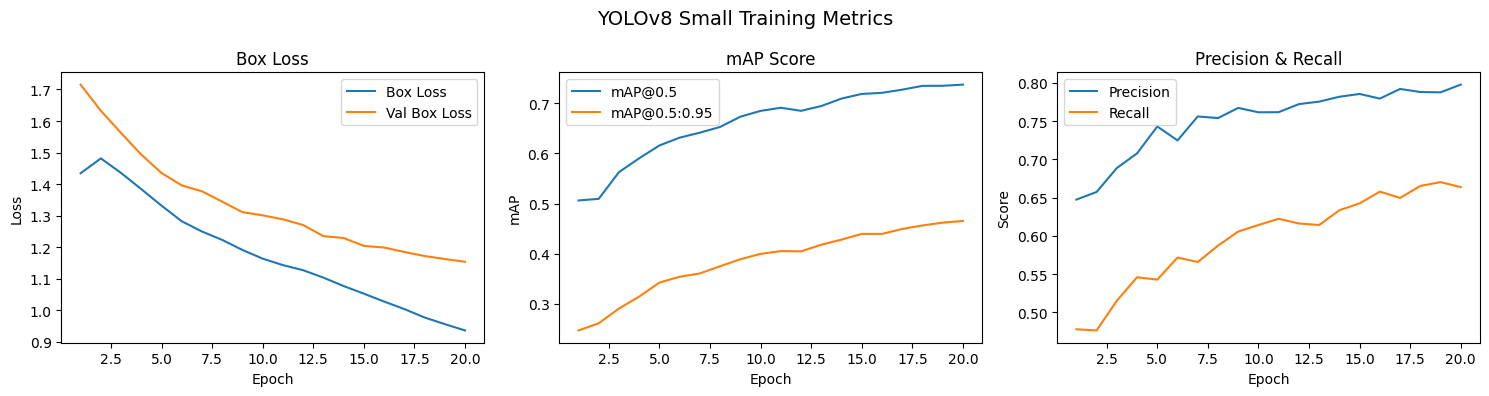

In [ ]:
metrics_path = os.path.join(small_results['train_results'].save_dir, 'results.csv')
if os.path.exists(metrics_path):
    df = pd.read_csv(metrics_path)
    epochs = df.index + 1
    plt.figure(figsize=(15, 4))
    plt.suptitle("YOLOv8 Small Training Metrics", fontsize=14)
    # Box Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, df['train/box_loss'], label='Box Loss')
    plt.plot(epochs, df['val/box_loss'], label='Val Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Box Loss')
    plt.legend()
    # mAP
    plt.subplot(1, 3, 2)
    plt.plot(epochs, df['metrics/mAP50(B)'], label='mAP@0.5')
    plt.plot(epochs, df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title('mAP Score')
    plt.legend()
    # Precision / Recall
    plt.subplot(1, 3, 3)
    plt.plot(epochs, df['metrics/precision(B)'], label='Precision')
    plt.plot(epochs, df['metrics/recall(B)'], label='Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Precision & Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print(f"Warning: Metrics file not found at {metrics_path}")


# Compares the performance of the trained YOLOv8 models (Nano, Small, and Medium).

In [ ]:
import pandas as pd
from tabulate import tabulate
comparison_data = {
    'Model': ['YOLOv8n', 'YOLOv8s', 'YOLOv8m'],
    'mAP50': [
        nano_results['val_results'].box.map50,
        small_results['val_results'].box.map50,
        medium_results['val_results'].box.map50
    ],
    'mAP50-95': [
        nano_results['val_results'].box.map,
        small_results['val_results'].box.map,
        medium_results['val_results'].box.map
    ],
    'Precision': [
        nano_results['val_results'].box.p[0],
        small_results['val_results'].box.p[0],
        medium_results['val_results'].box.p[0]
    ],
    'Recall': [
        nano_results['val_results'].box.r[0],
        small_results['val_results'].box.r[0],
        medium_results['val_results'].box.r[0]
    ],
    'F1-Score': [
        (2 * nano_results['val_results'].box.p[0] * nano_results['val_results'].box.r[0]) /
        (nano_results['val_results'].box.p[0] + nano_results['val_results'].box.r[0] + 1e-6),
        (2 * small_results['val_results'].box.p[0] * small_results['val_results'].box.r[0]) /
        (small_results['val_results'].box.p[0] + small_results['val_results'].box.r[0] + 1e-6),
        (2 * medium_results['val_results'].box.p[0] * medium_results['val_results'].box.r[0]) /
        (medium_results['val_results'].box.p[0] + medium_results['val_results'].box.r[0] + 1e-6),
    ],
    'Inference Time (ms)': [
        nano_results['inference_time'],
        small_results['inference_time'],
        medium_results['inference_time']
    ],
    'Model Size (MB)': [
        nano_results['model_size'],
        small_results['model_size'],
        medium_results['model_size']
    ],
    'Training Time (min)': [
        nano_results['training_time'] / 60,
        small_results['training_time'] / 60,
        medium_results['training_time'] / 60
    ]
}
# Create the DataFrame
comparison_df = pd.DataFrame(comparison_data)
# Display the table with formatting
print(tabulate(comparison_df.round(3), headers='keys', tablefmt='pretty', showindex=False))

+---------+-------+----------+-----------+--------+----------+---------------------+-----------------+---------------------+
|  Model  | mAP50 | mAP50-95 | Precision | Recall | F1-Score | Inference Time (ms) | Model Size (MB) | Training Time (min) |
+---------+-------+----------+-----------+--------+----------+---------------------+-----------------+---------------------+
| YOLOv8n | 0.688 |  0.407   |   0.76    | 0.617  |  0.681   |        0.017        |      5.939      |       59.381        |
| YOLOv8s | 0.737 |  0.466   |   0.797   | 0.665  |  0.725   |        0.025        |     21.453      |       91.858        |
| YOLOv8m | 0.764 |  0.502   |   0.811   | 0.694  |  0.748   |        0.04         |     49.598      |       182.429       |
+---------+-------+----------+-----------+--------+----------+---------------------+-----------------+---------------------+


# Bar plots to visualize the performance comparison of the YOLOv8 Nano, Small, and Medium models based on various metrics

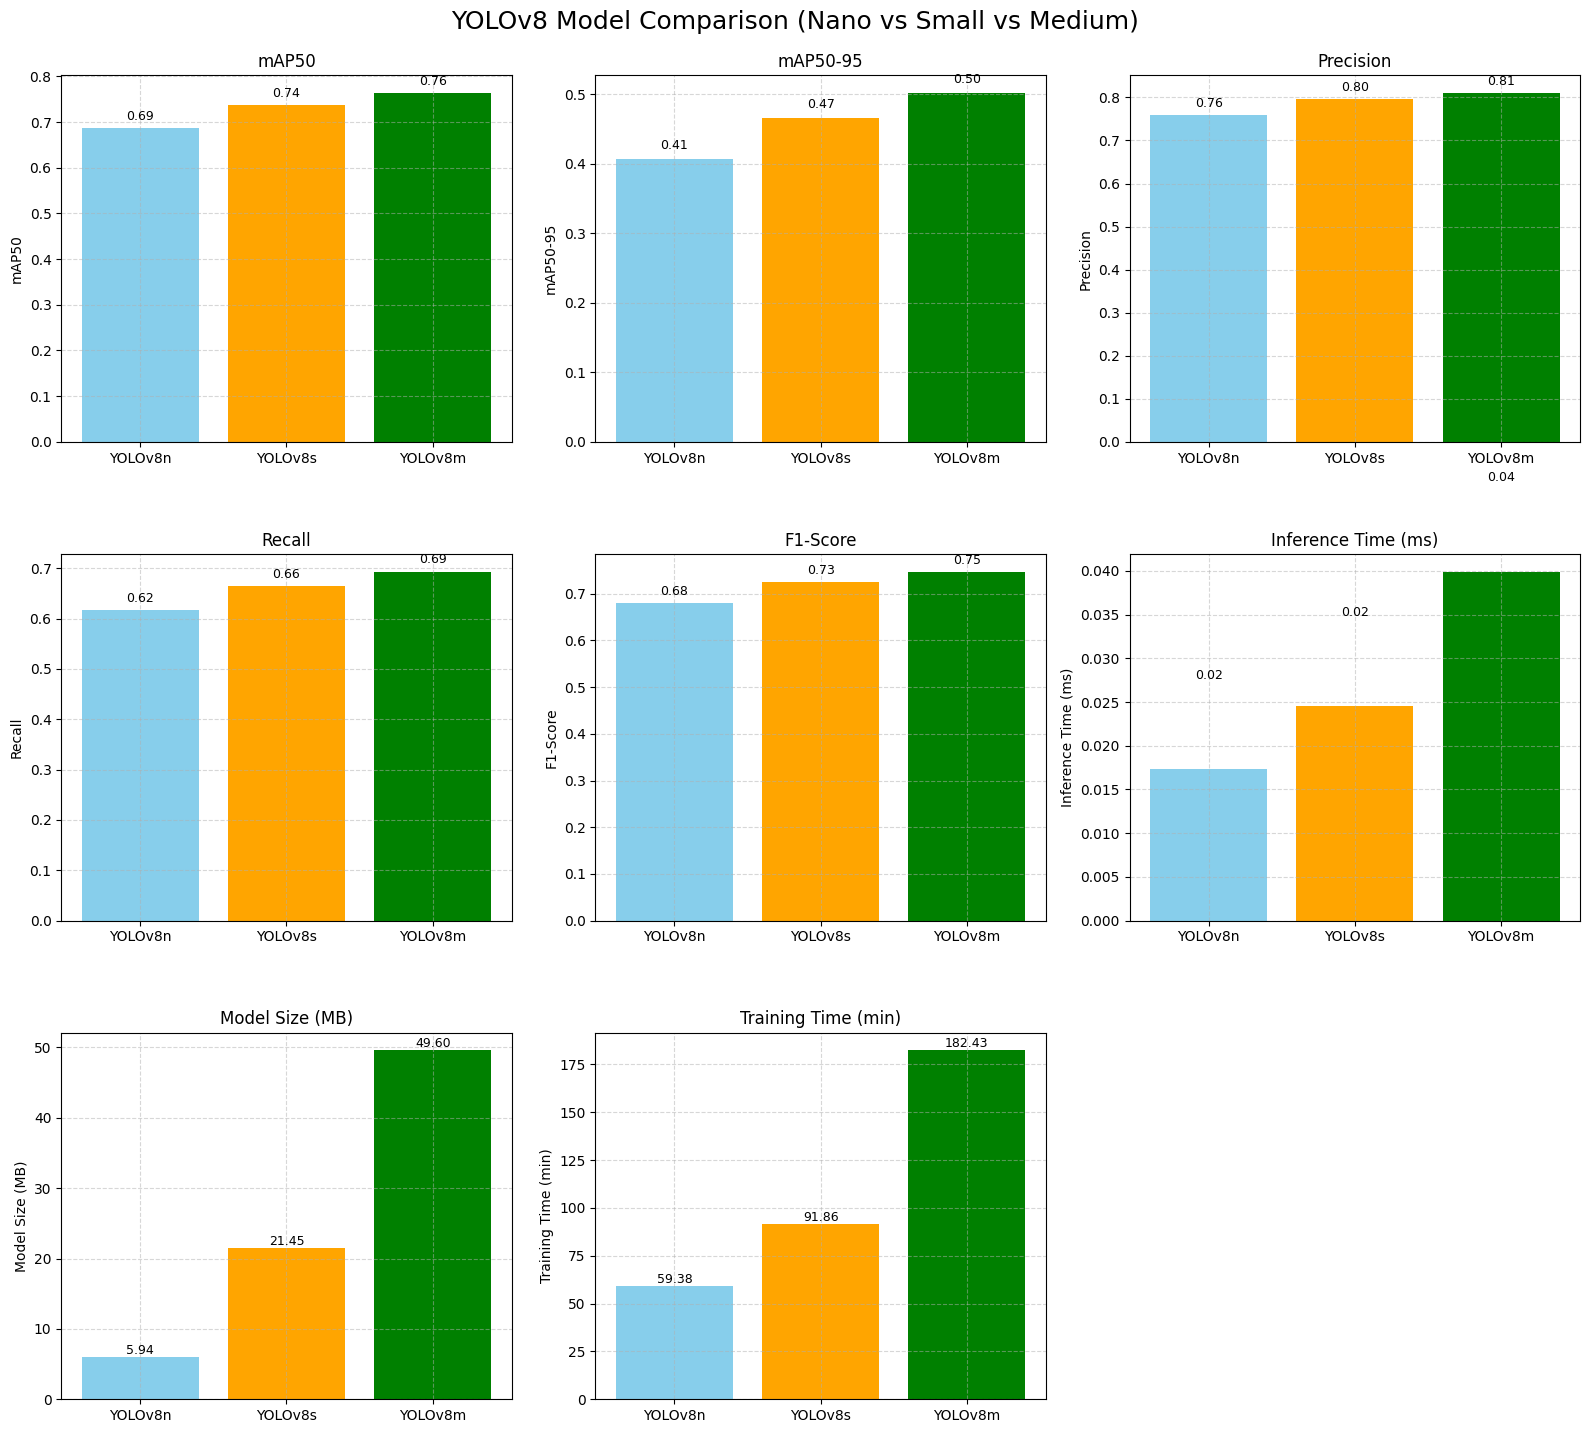

In [ ]:
import matplotlib.pyplot as plt
metrics_to_plot = ['mAP50', 'mAP50-95', 'Precision', 'Recall', 'F1-Score',
                   'Inference Time (ms)', 'Model Size (MB)', 'Training Time (min)']
plt.figure(figsize=(16, 14))
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(3, 3, i + 1)
    bars = plt.bar(comparison_df['Model'], comparison_df[metric], color=['skyblue', 'orange', 'green'])
    plt.title(metric)
    plt.ylabel(metric)
    plt.grid(True, linestyle='--', alpha=0.5)
    # Add value labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.01, f'{yval:.2f}',
                 ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.suptitle("YOLOv8 Model Comparison (Nano vs Small vs Medium)", fontsize=18, y=1.02)
plt.show()


In [ ]:
all_results = {
    'yolov8n': nano_results,
    'yolov8s': small_results,
    'yolov8m': medium_results
}
# Define model_variants here
model_variants = {
    'yolov8n': 'YOLOv8 Nano',
    'yolov8s': 'YOLOv8 Small',
    'yolov8m': 'YOLOv8 Medium'
}
data = []
for model_name, results in all_results.items():
    precision = results['val_results'].box.p
    if isinstance(precision, np.ndarray):
        precision = precision.mean()

    recall = results['val_results'].box.r
    if isinstance(recall, np.ndarray):
        recall = recall.mean()

    data.append({
        'Model': model_variants[model_name],
        'mAP50': f"{results['val_results'].box.map50:.3f}",
        'mAP50-95': f"{results['val_results'].box.map:.3f}",
        'Precision': f"{precision:.3f}",  # Format the single value
        'Recall': f"{recall:.3f}",      # Format the single value
        'F1-Score': f"{(2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0:.3f}",  # Calculate and format F1
        'Inference Time (ms)': f"{results['inference_time']:.2f}",
        'Model Size (MB)': f"{results['model_size']:.1f}",
        'Training Time (min)': f"{results['training_time']/60:.1f}"
    })

df = pd.DataFrame(data)

# Save to CSV
df.to_csv('/kaggle/working/model_comparison_HumanDetection/model_comparison.csv', index=False)

# Display as HTML table with styling
styled_df = df.style.background_gradient(subset=['mAP50', 'mAP50-95', 'Precision', 'Recall', 'F1-Score'], cmap='viridis')
display(HTML(styled_df.to_html()))

# Summary of each model's architecture and parameters

In [ ]:
# Define model variants
model_variants = ['yolov8n', 'yolov8s', 'yolov8m']
# Iterate through each model variant
for model_name in model_variants:
    # Load the model
    model = YOLO(f"{model_name}.pt")
    # Print the model summary
    print(f"{'='*50}")  # Separator line
    print(f"Model Summary for {model_name.upper()}:")
    model.info(verbose=True)  # Use verbose=True for detailed summary
    print(f"{'='*50}\n")  # Separator line

Model Summary for YOLOV8N:
YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs

Model Summary for YOLOV8S:
YOLOv8s summary: 129 layers, 11,166,560 parameters, 0 gradients, 28.8 GFLOPs

Model Summary for YOLOV8M:
YOLOv8m summary: 169 layers, 25,902,640 parameters, 0 gradients, 79.3 GFLOPs



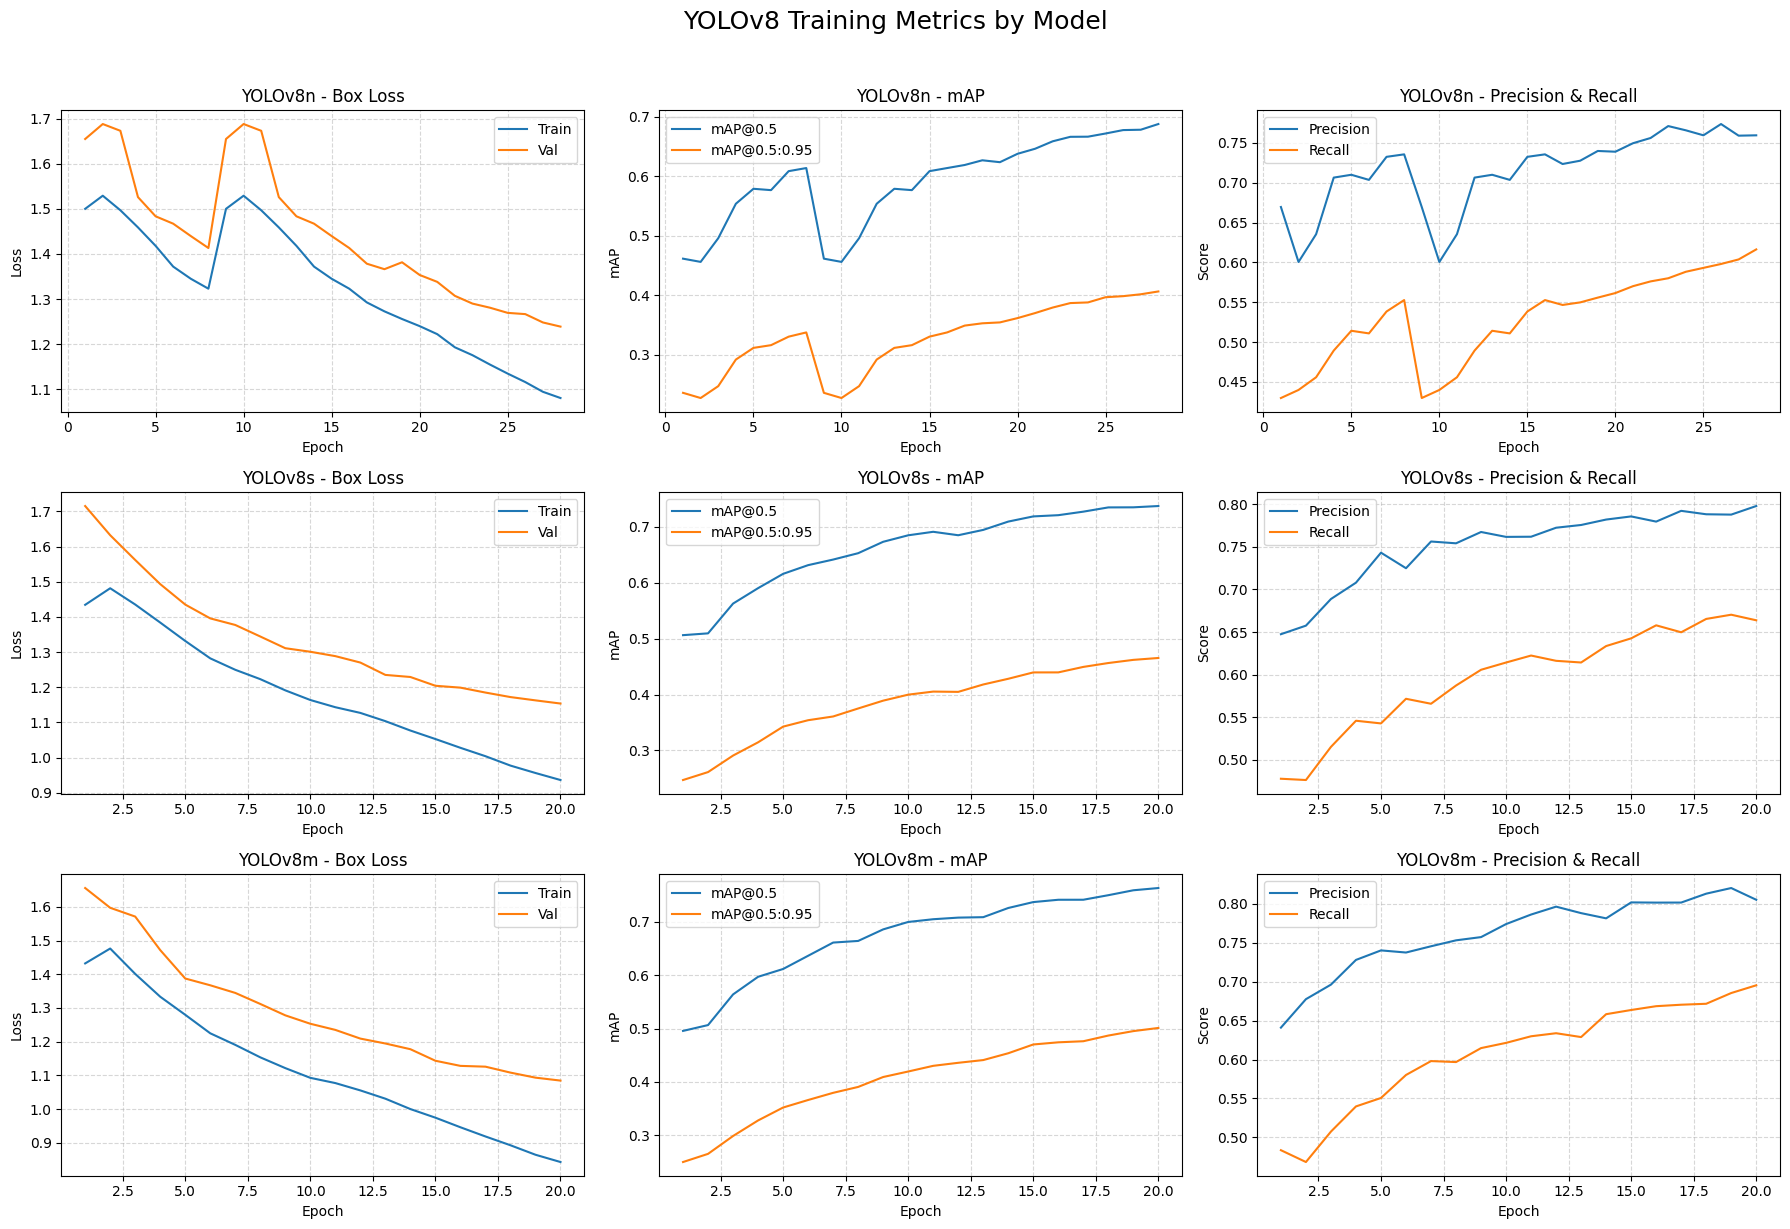

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

models = {
    'YOLOv8n': nano_results,
    'YOLOv8s': small_results,
    'YOLOv8m': medium_results
}

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
fig.suptitle("YOLOv8 Training Metrics by Model", fontsize=18, y=1.02)

for row_idx, (model_name, result) in enumerate(models.items()):
    metrics_path = os.path.join(result['train_results'].save_dir, 'results.csv')
    if not os.path.exists(metrics_path):
        print(f"Metrics file not found for {model_name}: {metrics_path}")
        continue

    df = pd.read_csv(metrics_path)
    epochs = df.index + 1

    # Box Loss
    axes[row_idx, 0].plot(epochs, df['train/box_loss'], label='Train')
    axes[row_idx, 0].plot(epochs, df['val/box_loss'], label='Val')
    axes[row_idx, 0].set_title(f'{model_name} - Box Loss')
    axes[row_idx, 0].set_xlabel('Epoch')
    axes[row_idx, 0].set_ylabel('Loss')
    axes[row_idx, 0].legend()
    axes[row_idx, 0].grid(True, linestyle='--', alpha=0.5)

    # mAP
    axes[row_idx, 1].plot(epochs, df['metrics/mAP50(B)'], label='mAP@0.5')
    axes[row_idx, 1].plot(epochs, df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
    axes[row_idx, 1].set_title(f'{model_name} - mAP')
    axes[row_idx, 1].set_xlabel('Epoch')
    axes[row_idx, 1].set_ylabel('mAP')
    axes[row_idx, 1].legend()
    axes[row_idx, 1].grid(True, linestyle='--', alpha=0.5)

    # Precision & Recall
    axes[row_idx, 2].plot(epochs, df['metrics/precision(B)'], label='Precision')
    axes[row_idx, 2].plot(epochs, df['metrics/recall(B)'], label='Recall')
    axes[row_idx, 2].set_title(f'{model_name} - Precision & Recall')
    axes[row_idx, 2].set_xlabel('Epoch')
    axes[row_idx, 2].set_ylabel('Score')
    axes[row_idx, 2].legend()
    axes[row_idx, 2].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


This code analyzes the comparison_df DataFrame to identify the best performing YOLOv8 model based on several metrics.

1. It finds the model with the highest mAP50 using idxmax() on the 'mAP50' column.
2. It finds the model with the highest mAP50-95 using idxmax() on the 'mAP50-95' column.
3. It finds the model with the highest F1-Score using idxmax() on the 'F1-Score' column.
4. It finds the model with the fastest inference time using idxmin() on the 'Inference Time (ms)' column.
5. It finds the model with the smallest size using idxmin() on the 'Model Size (MB)' column.
6. Finally, it prints the name of the best model for each of these metrics.

This helps in understanding which model is best suited depending on the desired performance criteria (accuracy, speed, or size).

In [ ]:
# Find the best model based on mAP50, F1-Score, Inference Time, and Model Size
best_mAP50_model = comparison_df.loc[comparison_df['mAP50'].idxmax()]['Model']
best_mAP50_95_model = comparison_df.loc[comparison_df['mAP50-95'].idxmax()]['Model']
best_F1_model = comparison_df.loc[comparison_df['F1-Score'].idxmax()]['Model']
fastest_inference_model = comparison_df.loc[comparison_df['Inference Time (ms)'].idxmin()]['Model']
smallest_model_size = comparison_df.loc[comparison_df['Model Size (MB)'].idxmin()]['Model']

print(f"Best mAP50 Model: {best_mAP50_model}")
print(f"Best mAP50-95 Model: {best_mAP50_95_model}")
print(f"Best F1-Score Model: {best_F1_model}")
print(f"Fastest Inference Time Model: {fastest_inference_model}")
print(f"Smallest Model Size Model: {smallest_model_size}")


Best mAP50 Model: YOLOv8m
Best mAP50-95 Model: YOLOv8m
Best F1-Score Model: YOLOv8m
Fastest Inference Time Model: YOLOv8n
Smallest Model Size Model: YOLOv8n


# Visualize the distribution of the dataset across the training, validation, and test splits.

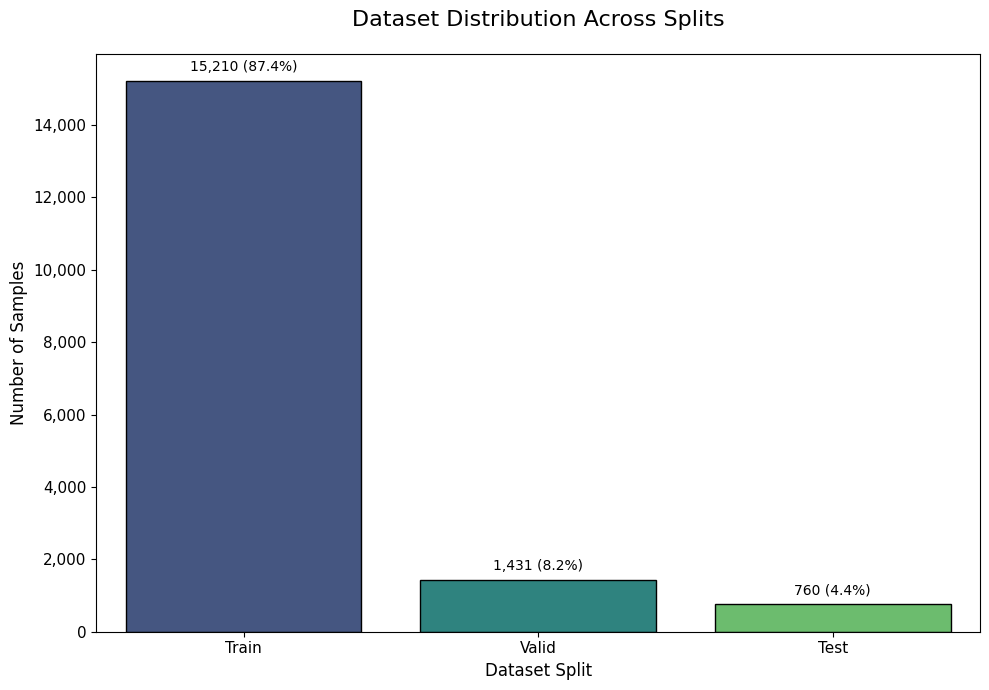

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Define paths and structure
SPLITS = ['train', 'valid', 'test']
DATA_PATH = ROOT_DIR
CLASS_NAMES = ['person']
data_dist = []
# Count images in each split
for split in SPLITS:
    split_path = os.path.join(DATA_PATH, split, 'images')
    count = len(os.listdir(split_path))
    data_dist.append({
        'Split': split.capitalize(),
        'Count': count
    })
# Create DataFrame
df = pd.DataFrame(data_dist)
total = df['Count'].sum()
# Plot
plt.figure(figsize=(10, 7))
ax = sns.barplot(x='Split', y='Count', data=df, palette='viridis', edgecolor='black')
# Add count and percentage labels
for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / total
    label = f"{int(height):,} ({percentage:.1f}%)"
    ax.annotate(label,
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=10)
# Format y-axis with commas
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title('Dataset Distribution Across Splits', fontsize=16, pad=20)
plt.xlabel('Dataset Split', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

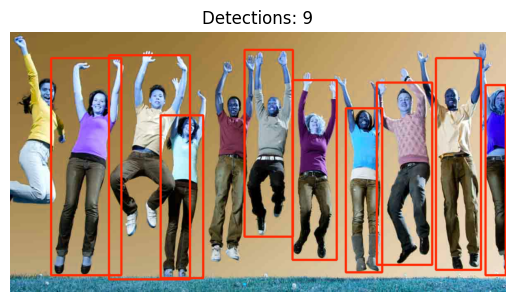

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load model
model = YOLO('/kaggle/working/model_comparison_HumanDetection/yolov8m/weights/best.pt')
img_path = '/kaggle/input/human-dataset/happy-people-group-fb.jpg'

# Predict
results = model.predict(img_path, verbose=False)

# Get boxes and count
boxes = results[0].boxes
num_detections = len(boxes)

# Plot
results_img = results[0].plot(labels=False, boxes=True)
plt.imshow(results_img)
plt.axis('off')
plt.title(f"Detections: {num_detections}")
plt.show()
